In [26]:
import sys
import numpy as np 
import pandas as pd 
from collections import Counter
from sklearn.metrics import classification_report

import cornac
from cornac.models.ncf.recom_mlp import MLP
from cornac.eval_methods import RatioSplit
from cornac.data.dataset import Dataset
from cornac.utils import cache

from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, auc, distributional_coverage, catalog_coverage, exp_var, get_top_k_items, logloss, mae, rmse, rsquared
from recommenders.models.cornac.cornac_utils import predict_ranking, predict

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
SEED = 42
VERBOSE = True

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

System version: 3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]
Cornac version: 1.14.1


---
Analysis Module

In [27]:


class PerformanceAnalyzer(object):
    def __init__(self, df, user_col, item_col, score_col, target_col, recType='explicit'):
        self.df = df 
        self.user_col = user_col 
        self.item_col = item_col 
        self.score_col = score_col
        self.target_col = target_col 
        self.rtype = recType
    
    def calc_mets(self, test_df):
        met_dict = {'root mean squared error': rmse, 'R-sqaured': rsquared, 'expected-variance': exp_var, 'mean abosolute error': mae,}

        if self.rtype == 'implicit':
            met_dict.update({'AUC': auc, 'logloss': logloss})

        met_results = {k: v(test_df, test_df, col_user=self.user_col, col_item=self.item_col, col_rating=self.target_col, col_prediction=self.score_col) for k,v in met_dict.items()}
        return met_results

    def calc_Kmets(self, test_df, k):
        met_dict = {'mean average precision': map_at_k, 'NDGC': ndcg_at_k, 'precision': precision_at_k, 'recall': recall_at_k}
        met_results = {i: v(test_df, test_df, col_user=self.user_col, col_item=self.item_col, col_rating=self.target_col, col_prediction=self.score_col, k=k) for i,v in met_dict.items()}
        return met_results

    def get_coverage_report(self, train_df):
        res_dict = {}
        try:
            res_dict['Catalog Coverage'] = catalog_coverage(train_df, self.df, col_item=self.item_col, col_user=self.user_col)
            res_dict['Distribution Coverage'] = distributional_coverage(train_df, self.df, col_item=self.item_col, col_user=self.user_col)
        except:
            print(f"Make sure the training dataset to have {self.item_col}, {self.user_col} as item columns & user column respectively.")
        return res_dict     

    def get_performance_analysis(self, k=5):
        met_results = self.calc_mets(self.df)
        met_results.update(self.calc_Kmets(self.df, k))
        return met_results

    def plot_performanceWk(self, ks=[5, 10, 25, 50], plt_size=(8, 6)):
        data_dict = {'value': [], 'metrics': [], 'k': []}
        for k in ks:
            eval_map = map_at_k(self.df, self.df, col_prediction=self.score_col, col_rating=self.target_col, col_item=self.item_col, col_user=self.user_col, k=k)
            eval_ndcg = ndcg_at_k(self.df, self.df, col_prediction=self.score_col, col_rating=self.target_col, col_item=self.item_col, col_user=self.user_col, k=k)
            eval_precision = precision_at_k(self.df, self.df, col_prediction=self.score_col, col_rating=self.target_col, col_item=self.item_col, col_user=self.user_col, k=k)
            eval_recall = recall_at_k(self.df, self.df, col_prediction=self.score_col, col_rating=self.target_col, col_item=self.item_col, col_user=self.user_col, k=k)
            data_dict['value'].extend([eval_map, eval_ndcg, eval_precision, eval_recall])
            data_dict['metrics'].extend(['map', 'ndgc', 'precision', 'recall'])
            data_dict['k'].extend([k, k, k, k])
        eval_result_df = pd.DataFrame(data_dict)

        plt.figure(figsize=plt_size)
        plot = sns.lineplot(data=eval_result_df, x='k', y='value', hue='metrics', marker='o')

        return eval_result_df, plot 
    
    def analyze_active_predictions(self, pred_active_thr, customer_acceptance_thr):
        alt_df1 = self.df.copy()
        alt_df1['is_pred'] = (alt_df1['score'] >= pred_active_thr).astype(int)
        alt_df1['customer_subs'] = 1 
        alt_df1['customer_likes'] = (alt_df1['rating'] >= customer_acceptance_thr).astype(int)

        report1 = classification_report(alt_df1['customer_subs'], alt_df1['is_pred'], zero_division=0, output_dict=True)
        report2 = classification_report(alt_df1['customer_likes'], alt_df1['is_pred'], zero_division=0, output_dict=True)
        return report1, report2



---
Test Dataset 

In [4]:
train_df = pd.read_csv('../data/ml_100k/train_data.csv')
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], unit='s')
print("Training Data > \n", train_df.head())


test_df = pd.read_csv('../data/ml_100k/test_data.csv')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], unit='s')
print("Test Data > \n", test_df.head())

pred_df = pd.read_csv('../data/ml_100k/predicted_data.csv')
pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp'], unit='s')
print("Predicted Results > \n", pred_df.head())

Training Data > 
    user_id  item_id  rating           timestamp
0        1        1       5 1997-09-22 22:02:38
1        1        2       3 1997-10-15 05:26:11
2        1        3       4 1997-11-03 07:42:40
3        1        4       3 1997-10-15 05:25:19
4        1        5       3 1998-03-13 01:15:12
Test Data > 
    user_id  item_id  rating           timestamp
0        1        6       5 1998-02-14 04:52:53
1        1       10       3 1997-10-01 08:05:18
2        1       12       5 1997-11-03 07:42:40
3        1       14       5 1997-09-22 22:01:46
4        1       17       3 1997-09-24 03:53:18
Predicted Results > 
    user_id  item_id  score  rating           timestamp
0        1        6      4       5 1998-02-14 04:52:53
1        1       10      4       3 1997-10-01 08:05:18
2        1       12      4       5 1997-11-03 07:42:40
3        1       14      4       5 1997-09-22 22:01:46
4        1       17      3       3 1997-09-24 03:53:18


---
Module Testing

In [29]:
scorer = PerformanceAnalyzer(pred_df, user_col='user_id', item_col='item_id', score_col='score', target_col='rating', recType='explicit')

In [30]:
scorer.get_coverage_report(train_df)

{'Catalog Coverage': 0.8545454545454545,
 'Distribution Coverage': 9.68472564107168}

In [31]:
scorer.get_performance_analysis(k=10)

{'root mean squared error': 1.0065535256507723,
 'R-sqaured': 0.2387546159259507,
 'expected-variance': 0.23973651652895045,
 'mean abosolute error': 0.72645,
 'mean average precision': 0.4848842973958476,
 'NDGC': 1.0,
 'precision': 0.9374727668845315,
 'recall': 0.4848842973958476}

(       value    metrics   k
 0   0.288998        map   5
 1   1.000000       ndgc   5
 2   0.979956  precision   5
 3   0.288998     recall   5
 4   0.484884        map  10
 5   1.000000       ndgc  10
 6   0.937473  precision  10
 7   0.484884     recall  10
 8   0.730123        map  25
 9   1.000000       ndgc  25
 10  0.753551  precision  25
 11  0.730123     recall  25
 12  0.871598        map  50
 13  1.000000       ndgc  50
 14  0.572157  precision  50
 15  0.871598     recall  50,
 <AxesSubplot:xlabel='k', ylabel='value'>)

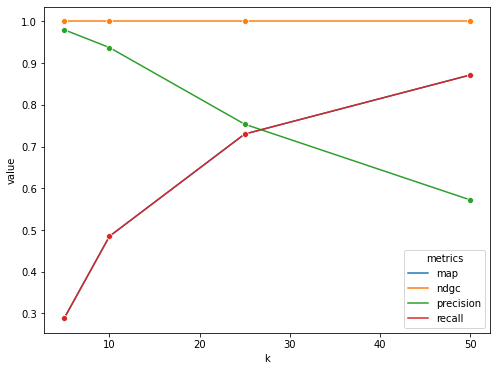

In [32]:
scorer.plot_performanceWk()

In [33]:
scorer.analyze_active_predictions(pred_active_thr=3, customer_acceptance_thr=4)

({'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
  '1': {'precision': 1.0,
   'recall': 0.9511,
   'f1-score': 0.9749372149044129,
   'support': 20000},
  'accuracy': 0.9511,
  'macro avg': {'precision': 0.5,
   'recall': 0.47555,
   'f1-score': 0.48746860745220644,
   'support': 20000},
  'weighted avg': {'precision': 1.0,
   'recall': 0.9511,
   'f1-score': 0.974937214904413,
   'support': 20000}},
 {'0': {'precision': 0.9049079754601227,
   'recall': 0.10096976611523104,
   'f1-score': 0.18166889048547674,
   'support': 8765},
  '1': {'precision': 0.5857428240984124,
   'recall': 0.9917222963951936,
   'f1-score': 0.736490729417986,
   'support': 11235},
  'accuracy': 0.60135,
  'macro avg': {'precision': 0.7453253997792675,
   'recall': 0.5463460312552123,
   'f1-score': 0.45907980995173137,
   'support': 20000},
  'weighted avg': {'precision': 0.7256169516826819,
   'recall': 0.60135,
   'f1-score': 0.4933400585058138,
   'support': 20000}})